# Implementing an image super resolution.
## Here I'm going to do some quick training as proof of concept (PoC).

### Imports

In [1]:
import gc
from models import generator_no_residual, generator_with_residual, discriminator
from utils import check_path_exists
from data_loader import load_images_with_truth
from loss_functions import perceptual_loss, perceptual_loss_16, perceptual_loss_19
from loss_functions import texture_loss_multi_layers, perceptual_plus_texture_loss, perceptual_16_plus_texture_loss
from visualizations import plot_images_for_compare, plot_images_for_compare_separate, compare_models, compare_models_single_image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
%matplotlib inline

Using TensorFlow backend.


### Variables declaration

In [2]:
# Enable this flag if running on the laptop with smaller GPU.
running_on_laptop = True

# This will use the smaller datasets (train_small, val_small, test_small).
use_small_dataset = True

# Set to true if you want to use CelebA dataset. Otherwise it will use MS COCO.
use_dataset_celeba = False

# Set to true and it will not execute training. Usefull when just want to plot the results.
disable_training = True

# Set to true if you want to load the current weights from the folder before training, so you can
# continue with the training
load_weights_before_training = False

# What to be the verbose level during training.
training_verbose = 2

enable_p = False
enable_p16 = False
enable_p19 = False
enable_t = False
enable_pt = True
enable_pt16 = True
enable_pt16_bci = False
enable_pt_bci = False
enable_pt16_no_res = False

train_epochs = 100
train_batch_size = 32
test_image_index_to_show = range(20)
optimizer = Adam(lr=0.0001)

if running_on_laptop:
    train_epochs = 10
    train_batch_size = 8
    test_image_index_to_show = range(20)
    optimizer = Adam(lr=0.001)

In [3]:
# Define the dataset path
dataset = "MSCOCO"
if use_dataset_celeba:
    dataset = "celeba"

if not use_small_dataset:
    train_dataset_path = './data/{0}/train/*'.format(dataset)
    validation_dataset_path = './data/{0}/val/*'.format(dataset)
    test_dataset_path = './data/{0}/test/*'.format(dataset)
else:
    train_dataset_path = './data/{0}/train_small/*'.format(dataset)
    validation_dataset_path = './data/{0}/val_small/*'.format(dataset)
    test_dataset_path = './data/{0}/test_small/*'.format(dataset)

print(train_dataset_path)
print(validation_dataset_path)
print(test_dataset_path)

./data/MSCOCO/train_small/*
./data/MSCOCO/val_small/*
./data/MSCOCO/test_small/*


In [4]:
checkpint_path_p = './saved_models/weights.best.train.mscoco.p.hdf5'
checkpoint_path_p16 = './saved_models/weights.best.train.mscoco.p16.hdf5'
checkpoint_path_p19 = './saved_models/weights.best.train.mscoco.p19.hdf5'
checkpoint_path_t = './saved_models/weights.best.train.mscoco.t.hdf5'
checkpoint_path_pt = './saved_models/weights.best.train.mscoco.pt.hdf5'
checkpoint_path_pt16 = './saved_models/weights.best.train.mscoco.pt16.hdf5'
checkpoint_path_pt16_bci = './saved_models/weights.best.train.mscoco.pt16_bci.hdf5'
checkpoint_path_pt_bci = './saved_models/weights.best.train.mscoco.pt_bci.hdf5'
checkpoint_path_pt16_no_res = './saved_models/weights.best.train.mscoco.pt16_no_res.hdf5'

if use_dataset_celeba:
    checkpint_path_p = './saved_models/weights.best.train.celeba.p.hdf5'
    checkpoint_path_p16 = './saved_models/weights.best.train.celeba.p16.hdf5'
    checkpoint_path_p19 = './saved_models/weights.best.train.celeba.p19.hdf5'
    checkpoint_path_t = './saved_models/weights.best.train.celeba.t.hdf5'
    checkpoint_path_pt = './saved_models/weights.best.train.celeba.pt.hdf5'
    checkpoint_path_pt16 = './saved_models/weights.best.train.celeba.pt16.hdf5'
    checkpoint_path_pt16_bci = './saved_models/weights.best.train.celeba.pt16_bci.hdf5'
    checkpoint_path_pt_bci = './saved_models/weights.best.train.celeba.pt_bci.hdf5'
    checkpoint_path_pt16_no_res = './saved_models/weights.best.train.celeba.pt16_no_res.hdf5'

### Helper functions

#### Train the model

In [5]:
# NOTE: Some of the parameters are used from the global space
def model_train(model, optimizer, loss_function, checkpoint_path, verbose=2):
    if load_weights_before_training:
        if check_path_exists(checkpoint_path):
            model.load_weights(checkpoint_path)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, 
                               verbose=verbose, save_best_only=True)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=verbose)

    model.fit(train_data_tensors, train_truth_tensors,
              validation_data=(validation_data_tensors, validation_truth_tensors),
              epochs=train_epochs, batch_size=train_batch_size, callbacks=[checkpointer, early_stopper], verbose=verbose)

#### Predict with the model

In [6]:
# NOTE: Some of the parameters are used from the global space
def model_predict(model, checkpoint_path):
    return
    model.load_weights(checkpoint_path)

    print('Predicting...')
    predictions = model.predict(test_data_tensors)

    print('Plotting the results...')
    plot_images_for_compare_separate(test_data_tensors, predictions, test_truth_tensors, test_image_index_to_show)

    print('All done!')

In [7]:
# NOTE: Some of the parameters are used from the global space
def model_predict_2(model, checkpoint_path):
    model.load_weights(checkpoint_path)

    print('Predicting...')
    predictions = model.predict(test_data_tensors)

    print('Plotting the results...')
    plot_images_for_compare(test_data_tensors, predictions, test_truth_tensors, test_image_index_to_show)

    print('All done!')

### Function to create models, train and predict

In [8]:
def model_p(get_model_only=False, summary=False):
    """
    """
    if not get_model_only:
        model = generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)
        if not disable_training:
            model_train(model=model, optimizer=optimizer, loss_function=perceptual_loss, checkpoint_path=perceptual_loss_checkpint_path,
                        verbose=training_verbose)
        model_predict(model, perceptual_loss_checkpint_path)
        # Free the memory
        del model
        gc.collect()
    
    # Recreate the model and return it
    return generator_with_residual(input_shape=train_data.shape[1:], summary=False, add_bicubic=False)

#### Define the functions to load the images

For training, we use all color images in MSCOCO [31]
that have at least 384 pixels on the short side resulting in
roughly 200k images. All images are cropped centrally to a
square and then downsampled to 256×256 to reduce noise
and JPEG artifacts. During training, we fix the size of the
input ILR to 32×32. As the scale of objects in the MSCOCO
dataset is too small when downsampled to such a small size,
we downsample the 256×256 images by  and then crop
these to patches of size 32×32. After training the model
for any given scaling factor , the input to the fully convolutional
network at test time can be an image of arbitrary
dimensions w×h which is then upscaled to (w)×(h).

#### Read the input images

In [9]:
if not disable_training
    print('Loading train data:')
    train_data, train_truth = load_images_with_truth(train_dataset_path, 4)
    train_data_tensors = train_data.astype('float32')/255
    train_truth_tensors = train_truth.astype('float32')/255

    print('Loading validation data:')
    validation_data, validation_truth = load_images_with_truth(validation_dataset_path, 4)
    validation_data_tensors = validation_data.astype('float32')/255
    validation_truth_tensors = validation_truth.astype('float32')/255

    print("Train images: ", len(train_data))
    print('Validation images: ', len(validation_data))


print('Loading test data:')
test_data, test_truth = load_images_with_truth(test_dataset_path, 4)

test_data_tensors = test_data.astype('float32')/255
test_truth_tensors = test_truth.astype('float32')/255

print("Test images: ", len(test_data))

train_data_shape = (32, 32, 3)

Loading train data:


100%|████████████████████████████████████████████████████████████████████████████████| 600/600 [00:19<00:00, 19.82it/s]


Loading validation data:


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.16it/s]


Loading test data:


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 29.62it/s]


Train images:  600
Validation images:  100
Test images:  20


### We need to create separate models even though that they are based on the same architecture. This is because we want to have new default parameters each time.

In [10]:
if enable_p:
    model_p = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    if not disable_training:
        print("Training P")
        model_train(model=model_p, optimizer=optimizer, loss_function=perceptual_loss,
                    checkpoint_path=checkpint_path_p, verbose=training_verbose)
    model_predict(model_p, checkpint_path_p)
    del model_p
    gc.collect()

### Peceptual loss based on VGG19 (block3_pool)

In [11]:
if enable_p19:
    model_p19 = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    if not disable_training:
        print("Training P19")
        model_train(model=model_p19, optimizer=optimizer, loss_function=perceptual_loss_19,
                    checkpoint_path=checkpoint_path_p19)
    model_predict(model=model_p19, checkpoint_path=checkpoint_path_p19)
    del model_p19
    gc.collect()

### Peceptual loss based on VGG16 (block3_pool)

In [12]:
if enable_p16:
    model_p16 = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    if not disable_training:
        print("Training P16")
        model_train(model=model_p16, optimizer=optimizer, loss_function=perceptual_loss_16,
                    checkpoint_path=checkpoint_path_p16, verbose=training_verbose)
    model_predict(model=model_p16, checkpoint_path=checkpoint_path_p16)
    del model_p16
    gc.collect()

### Texture loss (multi layers)

In [13]:
if enable_t:
    model_t = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    if not disable_training:
        print("Training T")
        model_train(model=model_t, optimizer=optimizer, loss_function=texture_loss_multi_layers,
                    checkpoint_path=checkpoint_path_t, verbose=training_verbose)
    model_predict(model=model_t, checkpoint_path=checkpoint_path_t)
    del model_t
    gc.collect()

### Texture loss plus perceptual loss

In [14]:
if enable_pt:
    model_pt = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    if not disable_training:
        print("Training PT")
        model_train(model=model_pt, optimizer=optimizer, loss_function=perceptual_plus_texture_loss,
                    checkpoint_path=checkpoint_path_pt, verbose=training_verbose)
    model_predict(model=model_pt, checkpoint_path=checkpoint_path_pt)
    del model_pt
    gc.collect()

### Peceptual loss 16 + texture loss

In [15]:
if enable_pt16:
    model_pt16 = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    if not disable_training:
        print("Training P16")
        model_train(model=model_pt16, optimizer=optimizer, loss_function=perceptual_16_plus_texture_loss,
                    checkpoint_path=checkpoint_path_pt16, verbose=training_verbose)
    model_predict(model=model_pt16, checkpoint_path=checkpoint_path_pt16)
    del model_pt16
    gc.collect()

## Let's try some with bicubic interpolation included

### Peceptual loss 16 + texture loss. Bicubic interpolation included in the model.

In [16]:
if enable_pt16_bci:
    model_pt16_bci = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=True)
    if not disable_training:
        print("Training PT16_BCI")
        model_train(model=model_pt16_bci, optimizer=optimizer, loss_function=perceptual_16_plus_texture_loss,
                    checkpoint_path=checkpoint_path_pt16_bci, verbose=training_verbose)
    model_predict(model=model_pt16_bci, checkpoint_path=checkpoint_path_pt16_bci)
    del model_pt16_bci
    gc.collect()

### Perceptual plus texture loss

In [17]:
if enable_pt_bci:
    model_pt_bci = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=True)
    if not disable_training:
        print("Training PT_BCI")
        model_train(model=model_pt_bci, optimizer=optimizer, loss_function=perceptual_plus_texture_loss,
                    checkpoint_path=checkpoint_path_pt_bci, verbose=training_verbose)
    model_predict(model=model_pt_bci, checkpoint_path=checkpoint_path_pt_bci)
    del model_pt_bci
    gc.collect()

### Peceptual loss 16 + texture loss. No residual network.

In [18]:
if enable_pt16_no_res:
    model_pt16_no_res = generator_no_residual(input_shape=train_data_shape, summary=False)
    if not disable_training:
        print("Training PT16_NO_RES")
        model_train(model=model_pt16_no_res, optimizer=optimizer,
                    loss_function=perceptual_16_plus_texture_loss,
                    checkpoint_path=checkpoint_path_pt16_no_res, verbose=training_verbose)
    model_predict(model=model_pt16_no_res,
                  checkpoint_path=checkpoint_path_pt16_no_res)
    del model_pt16_no_res
    gc.collect()

## Compare all of the models at the same time

In [19]:
models_data = []

if enable_p:
    model_p = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    models_data.append({'name': "P", 'model': model_p, 'checkpoint': checkpint_path_p})

if enable_p19:
    model_p19 = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    models_data.append({'name': "P VGG19", 'model': model_p19, 'checkpoint': checkpoint_path_p19})

if enable_p16:
    model_p16 = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    models_data.append({'name': "P VGG16", 'model': model_p16, 'checkpoint': checkpoint_path_p16})

if enable_t:
    model_t = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    models_data.append({'name': "T", 'model': model_t, 'checkpoint': checkpoint_path_t})

if enable_pt:
    model_pt = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    models_data.append({'name': "PT", 'model': model_pt,
                        'checkpoint': checkpoint_path_pt})

if enable_pt16:
    model_pt16 = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=False)
    models_data.append({'name': "PT VGG16", 'model': model_pt16,
                        'checkpoint': checkpoint_path_pt16})

if enable_pt16_bci:
    model_pt16_bci = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=True)
    models_data.append({'name': "PT VGG16 (BCI)", 'model': model_pt16_bci,
                        'checkpoint': checkpoint_path_pt16_bci})

if enable_pt_bci:
    model_pt_bci = generator_with_residual(input_shape=train_data_shape, summary=False, add_bicubic=True)
    models_data.append({'name': "PT (BCI)", 'model': model_pt_bci,
                        'checkpoint': checkpoint_path_pt_bci})

if enable_pt16_no_res:
    model_pt16_no_res = generator_no_residual(input_shape=train_data_shape, summary=False)
    models_data.append({'name': "PT VGG16 (NR)", 'model': model_pt16_no_res,
                        'checkpoint': checkpoint_path_pt16_no_res})

## Plot the images in higher dimension

Plotting the results...
Image: 1


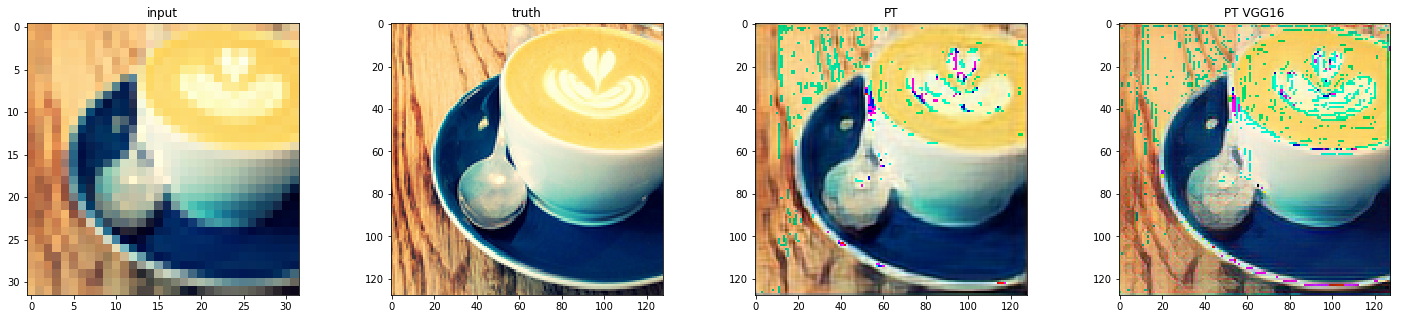


Image: 2


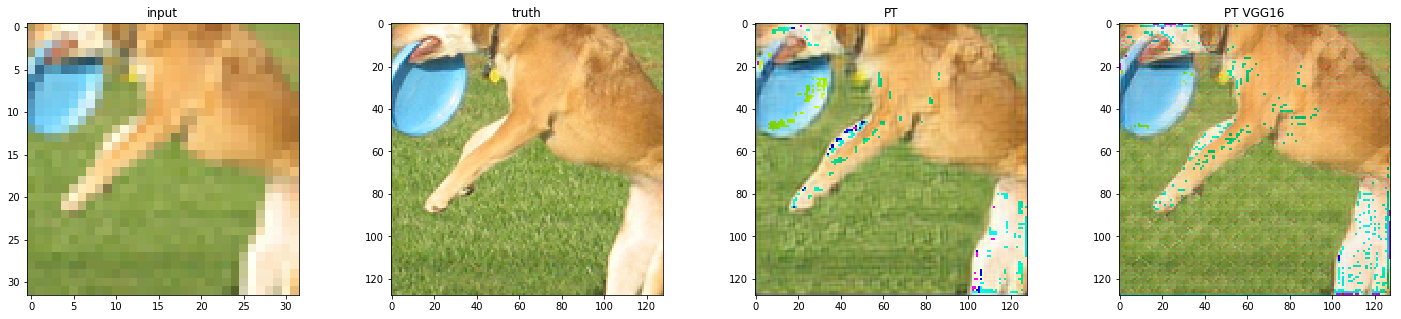


Image: 3


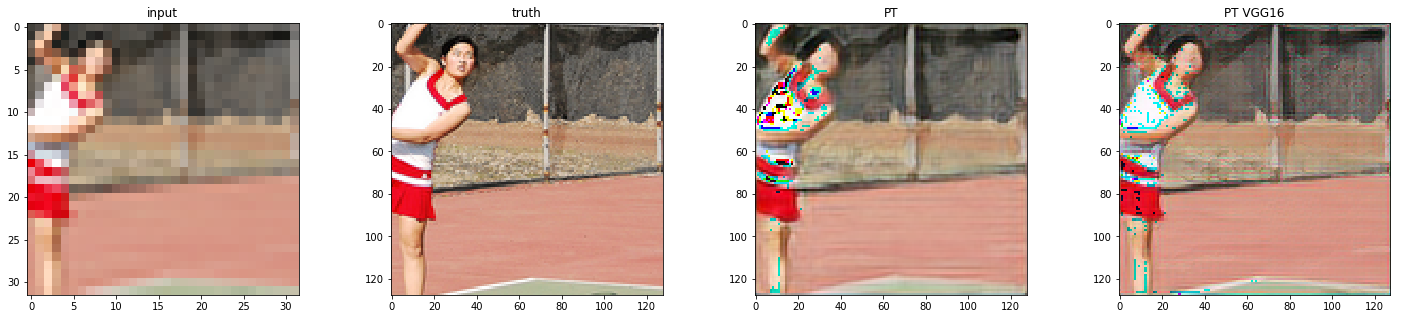


Image: 4


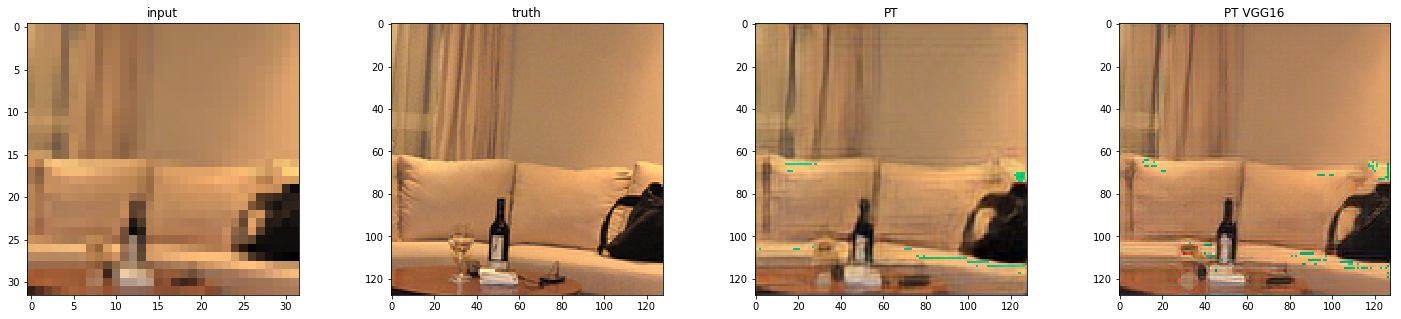


Image: 5


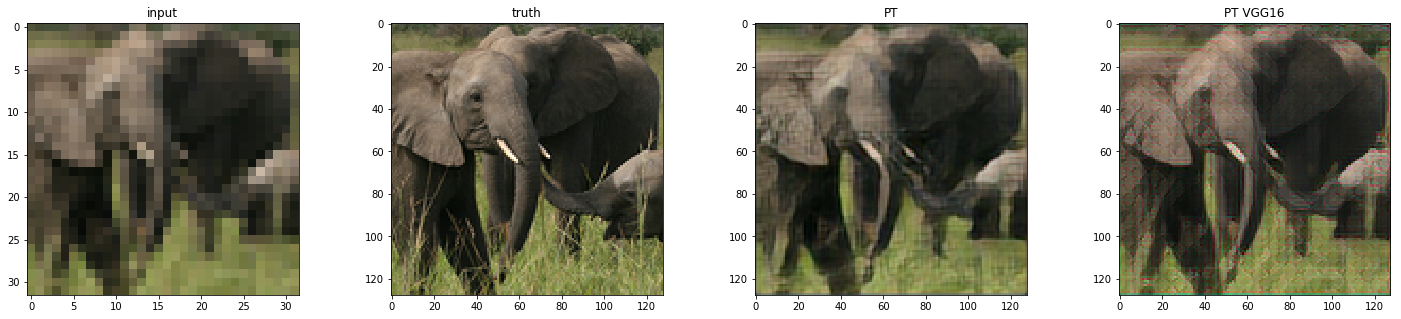


Image: 6


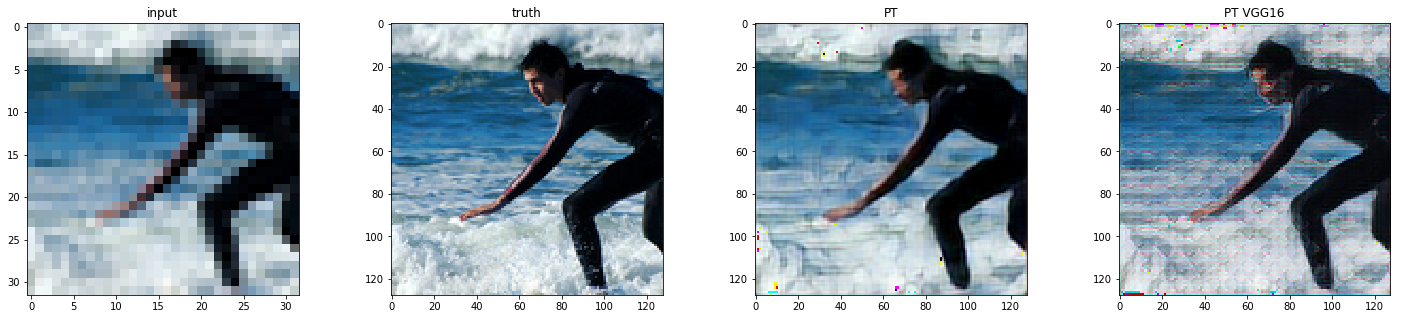


Image: 7


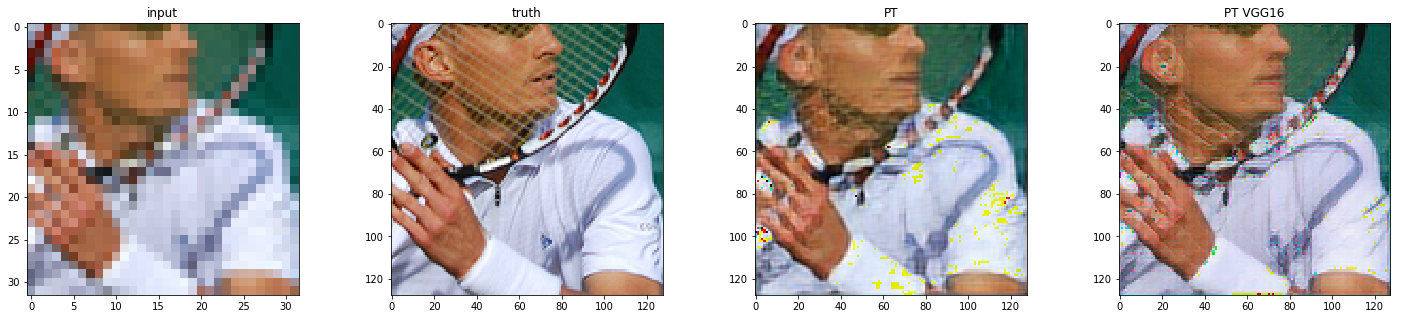


Image: 8


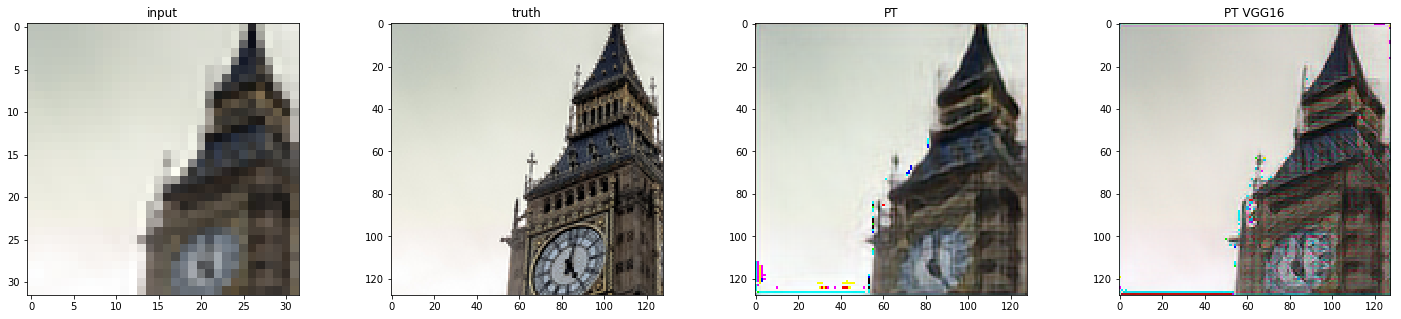


Image: 9


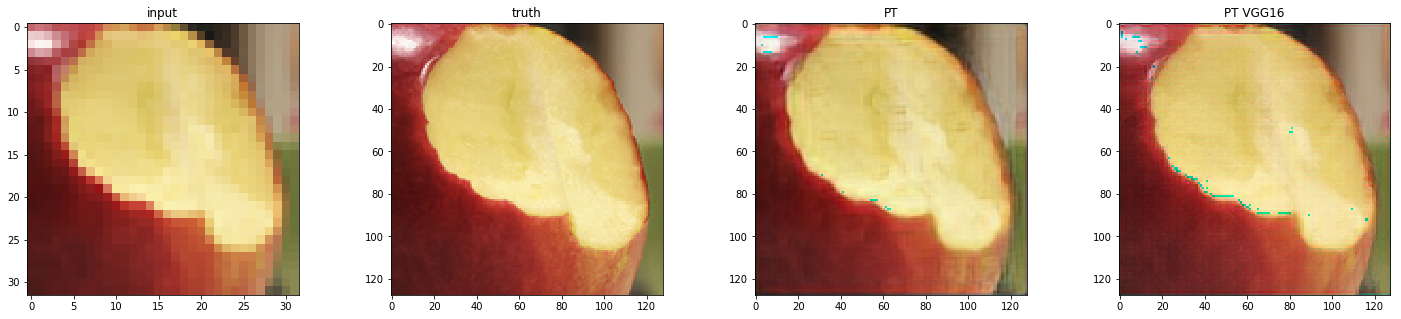


Image: 10


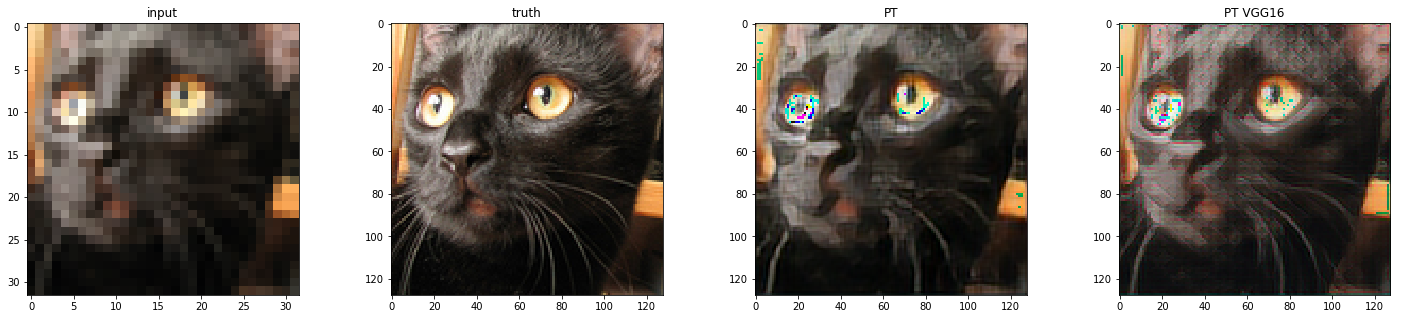


Image: 11


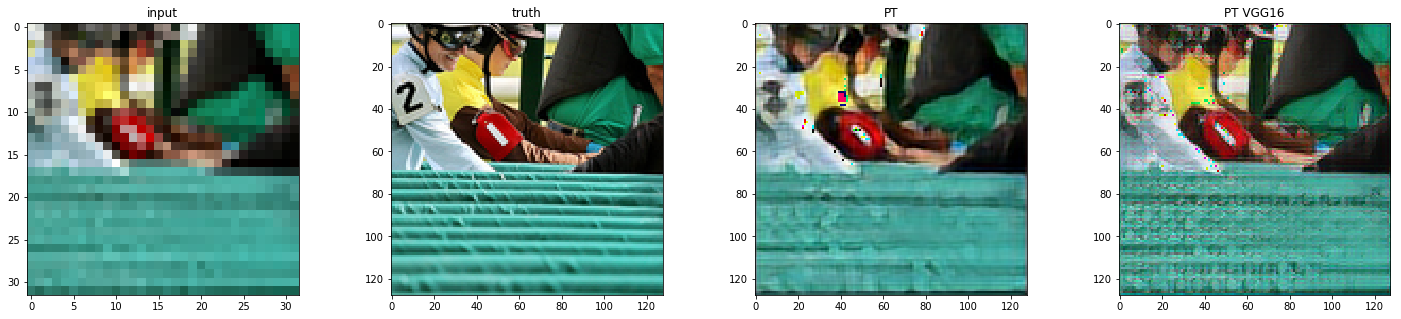


Image: 12


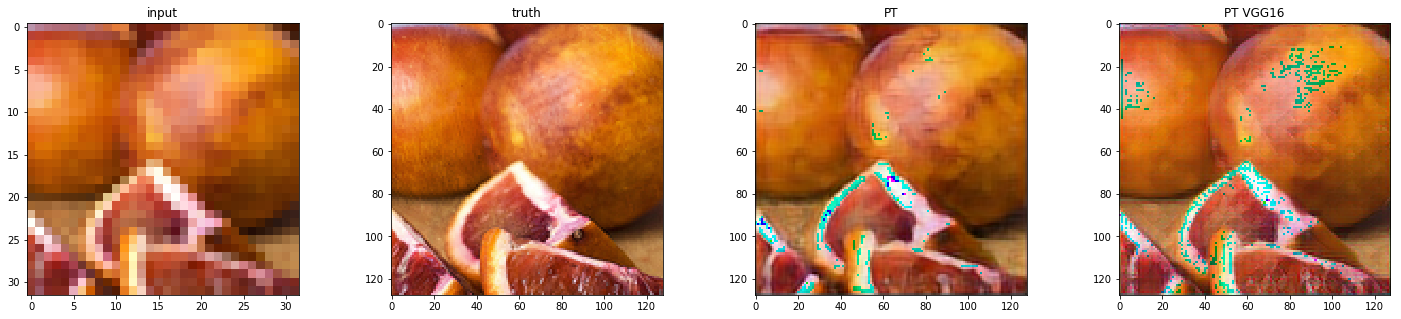


Image: 13


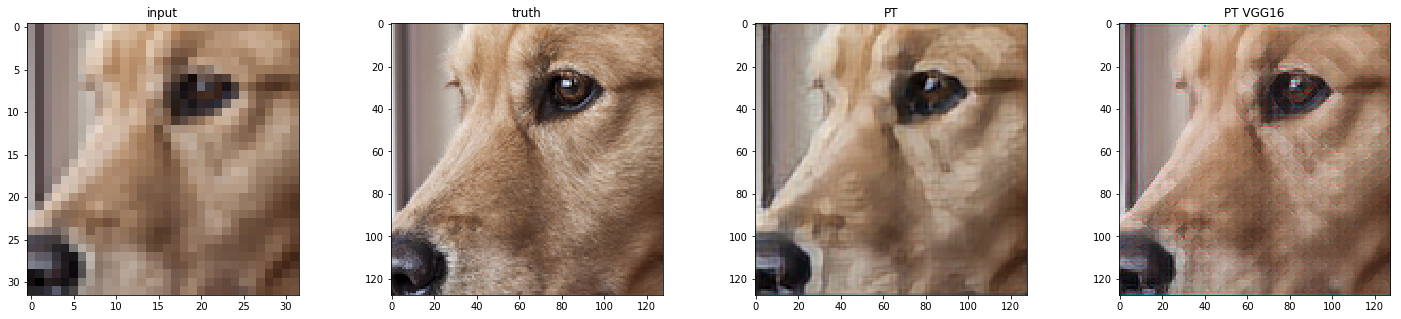


Image: 14


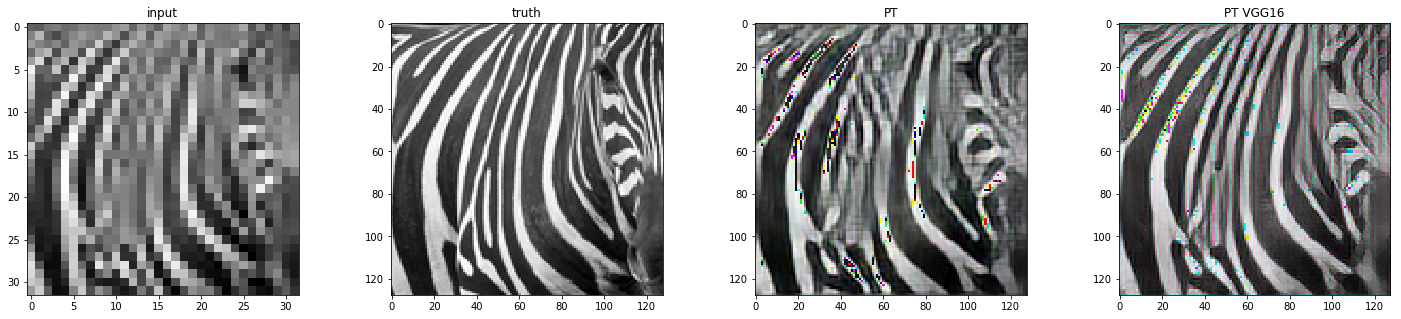


Image: 15


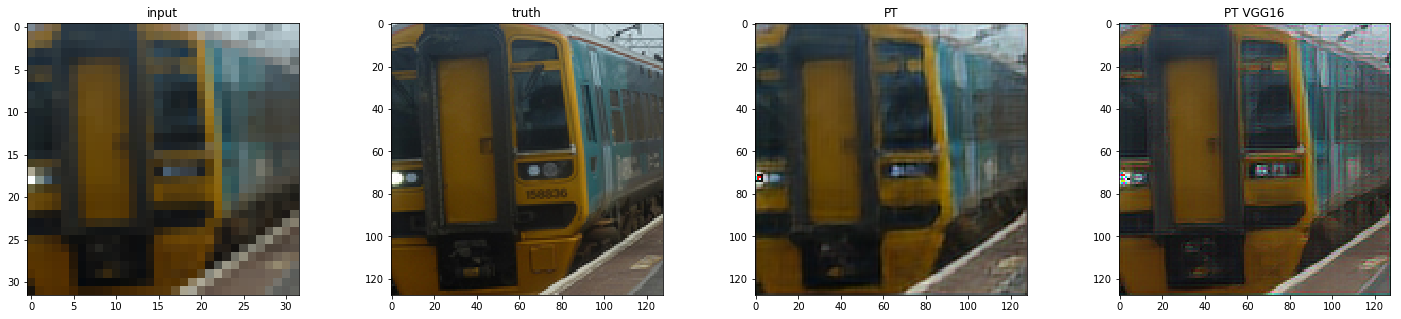


Image: 16


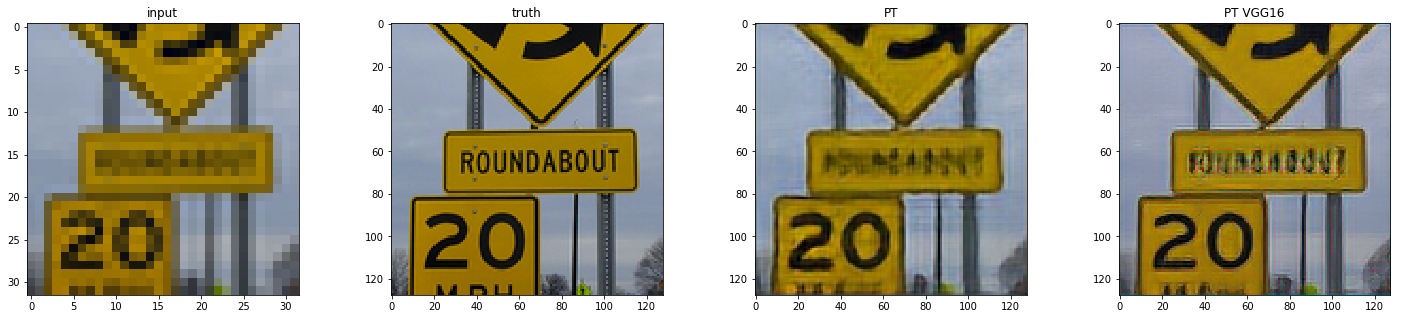


Image: 17


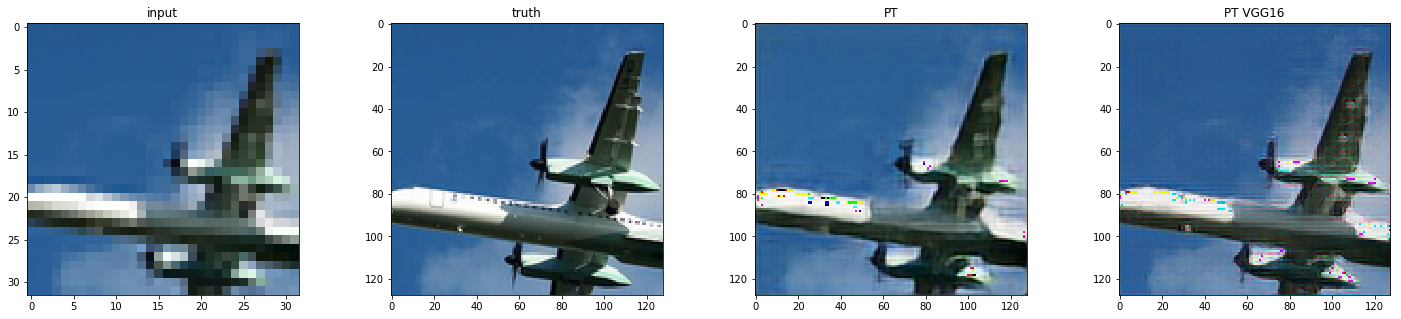


Image: 18


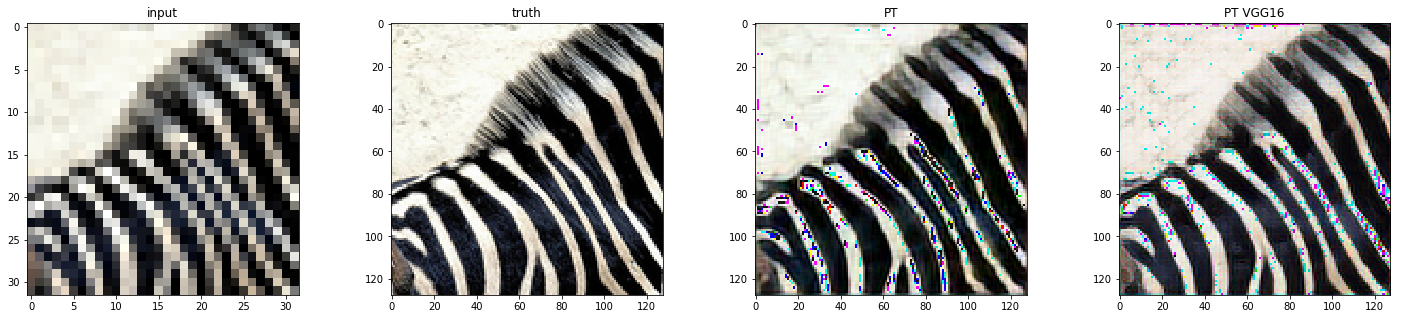


Image: 19


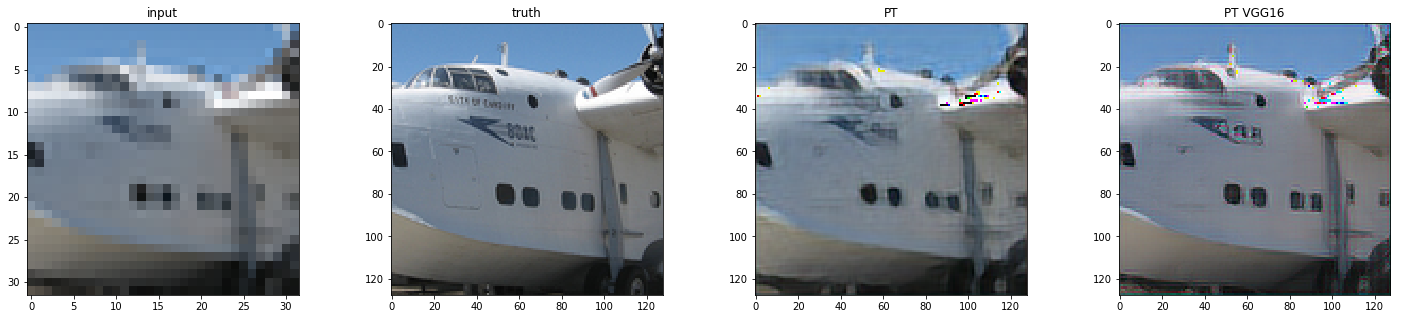


Image: 20


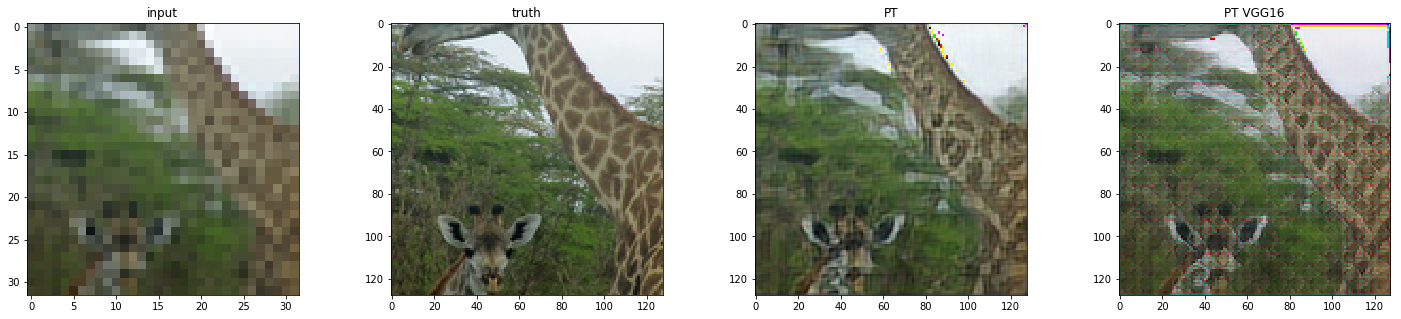


All done!


In [20]:
compare_models_single_image(test_data_tensors, test_truth_tensors, models_data, test_image_index_to_show, show_input=True, show_interpolated=False)